In [ ]:
import sys
import os 
from pathlib import Path

project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import glob
from rvp import AllocationData, AllocationProblem
from rvp.utilities import PartitionedUtility, CRRAUtility
from rvp.constraints import CoverageConstraint
from rvp.policies import RankingPolicy
from rvp.comparison import LeverComparison, plot_welfare_curve, optimize_budget_with_residual_benefit, plot_budget_allocation_stacked
from rvp.levers import DataLabelingLever, ExpandCoverageLever, CRRABenefitLever


# Case Study: Poverty Targeting in Ethopia

### Read Data

In [ ]:
folder_path = "data/poverty-targeting"
files = sorted(glob.glob(f'{folder_path}/seed_*.csv'))
data_list = [pd.read_csv(f) for f in files]

## What is the value of prediction for cash transfers?

In [10]:
data = AllocationData(df = data_list)
policy = RankingPolicy(ascending=True)

utility_step = PartitionedUtility(thresholds=[0.5], values=[1, 0], threshold_type='percentile')

### Value of Prediction as Function of Capacity

In [11]:
capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=1
)


utility_crra = CRRAUtility(rho=3.0, b=100)
constraint = CoverageConstraint(max_coverage=0.01, population_size=data.n)

problem_crra = AllocationProblem(data = data,
                            utility = utility_crra, 
                            constraint = constraint,
                            policy=policy)

problem_step = AllocationProblem(data = data,
                            utility = utility_step, 
                            constraint = constraint,
                            policy=policy)

(0.0, 33.13599926792161)

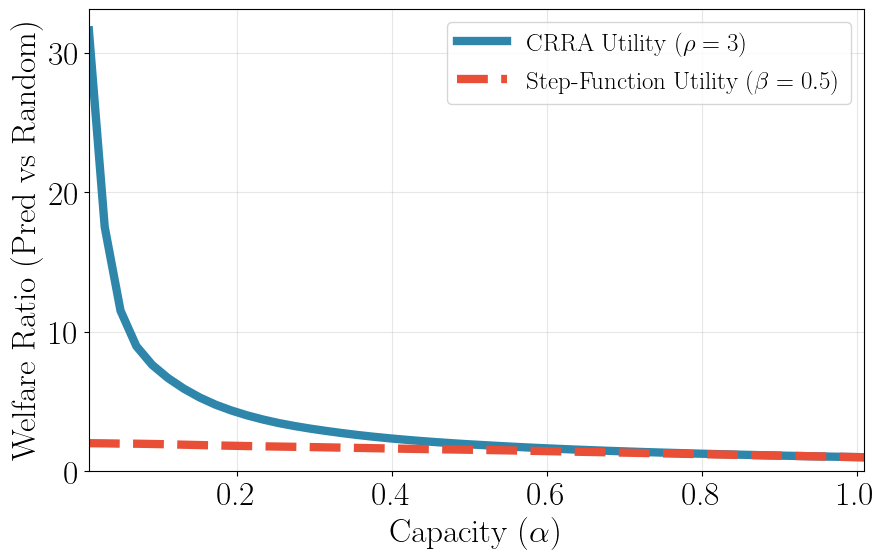

In [12]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 24

fig, ax = plt.subplots(figsize=(10, 6))

# All individuals
plot_welfare_curve(
    problem=problem_crra,
    lever=capacity_lever,
    theta_range=(1e-6, 1.0),
    ax=ax,
    xlabel='Capacity Increase (pp)',
    ylabel='Welfare Ratio (Pred vs Random)',
    # color='#F18F01',
    label=r'CRRA Utility ($\rho=3$)',
    subgroup_mask=None,
    linestyle='-',
    welfare_metric='utility_ratio',
    show_baseline=True,
    color='#2E86AB',
)


plot_welfare_curve(
    problem=problem_step,
    lever=capacity_lever,
    theta_range=(1e-6, 1.0),
    ax=ax,
    xlabel='Capacity Increase (pp)',
    ylabel='Welfare Ratio (Pred vs Random)',
     color='#E94F37',
    label=r'Step-Function Utility ($\beta=0.5$)',
    subgroup_mask=None,
    linestyle='--',
    welfare_metric='utility_ratio',
    show_baseline=True
)


ax.legend(fontsize=18)
baseline_alpha = problem_crra.constraint.get_capacity() / problem_crra.data.n
capacities = np.arange(0.2, 1.01, 0.2)
thetas = capacities - baseline_alpha

ax.set_xticks(thetas)
ax.set_xticklabels([f'{c:.1f}' for c in capacities])

ax.set_xlabel(r'Capacity ($\alpha$)')
ax.set_ylim(bottom=0)

### Value of Prediction as Function of Benefits

In [13]:
benefit_lever = CRRABenefitLever(
    name="Transfer size",
    new_benefit=100
)


utility_crra = CRRAUtility(rho=3.0, b=1)
constraint = CoverageConstraint(max_coverage=0.2, population_size=data.n)

problem_crra = AllocationProblem(data = data,
                            utility = utility_crra, 
                            constraint = constraint,
                            policy=policy)

problem_step = AllocationProblem(data = data,
                            utility = utility_step, 
                            constraint = constraint,
                            policy=policy)

(0.0, 4.725970501499327)

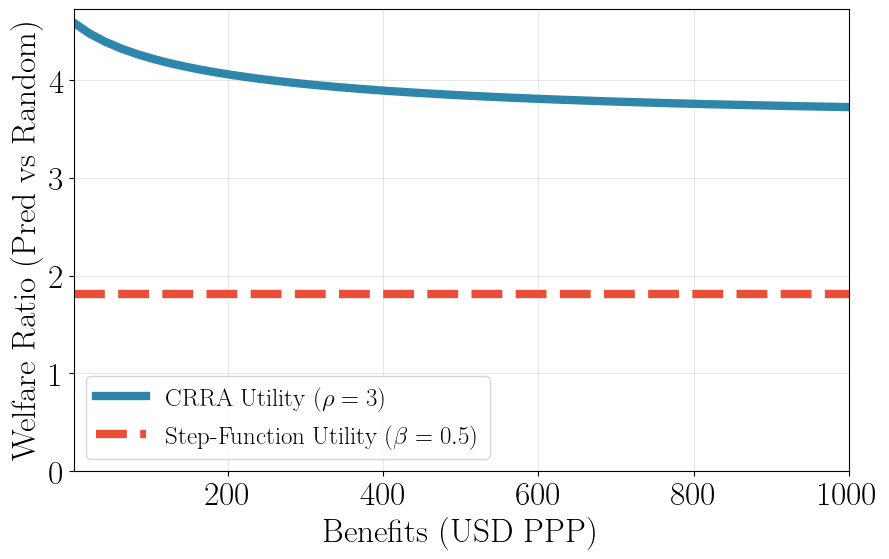

In [14]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 24

fig, ax = plt.subplots(figsize=(10, 6))

# All individuals
plot_welfare_curve(
    problem=problem_crra,
    lever=benefit_lever,
    theta_range=(1, 1000),
    ax=ax,
    xlabel='Benefits',
    ylabel='Welfare Ratio (Pred vs Random)',
    label=r'CRRA Utility ($\rho=3$)',
    subgroup_mask=None,
    linestyle='-',
    color='#2E86AB',
    welfare_metric='utility_ratio',
    show_baseline=True
)

utility_step = problem_step.evaluate()['utility_ratio']

ax.axhline(y=utility_step,  color='#E94F37', linestyle='--', linewidth=6, label=r'Step-Function Utility ($\beta=0.5$)')


ax.legend(fontsize=18)

ax.set_xlabel(r'Benefits (USD PPP)')
ax.set_ylim(bottom=0)

## What is the relative value of improving prediction via test-time data collection vs increasing program capacity?

In [15]:
data = AllocationData(df = data_list)
policy = RankingPolicy(ascending=True)

utility_crra = CRRAUtility(rho=3.0, b=100)
utility_step = PartitionedUtility(thresholds=[0.5], values=[1, 0], threshold_type='percentile')

constraint = CoverageConstraint(max_coverage=1e-3, population_size=data.n)

problem_crra = AllocationProblem(data = data,
                            utility = utility_crra, 
                            constraint = constraint,
                            policy=policy)

problem_step = AllocationProblem(data = data,
                            utility = utility_step, 
                            constraint = constraint,
                            policy=policy)

In [16]:
datalabeling_lever = DataLabelingLever(
    name="Data collection",
    label_share=0.5,
    cost_per_label=13.0,
    ascending=True,
    seed=42,
)

capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=100
)

comparison_step = LeverComparison(problem=problem_step,
                             lever_a=datalabeling_lever,
                             lever_b=capacity_lever)

comparison_crra = LeverComparison(problem=problem_crra,
                             lever_a=datalabeling_lever,
                             lever_b=capacity_lever)

In [17]:
results_crra = comparison_crra.optimize_budget(budget_range=[1, 100000], n_budget_points=10, grid_density=10)
results_step = comparison_step.optimize_budget(budget_range=[1, 100000], n_budget_points=10, grid_density=10)

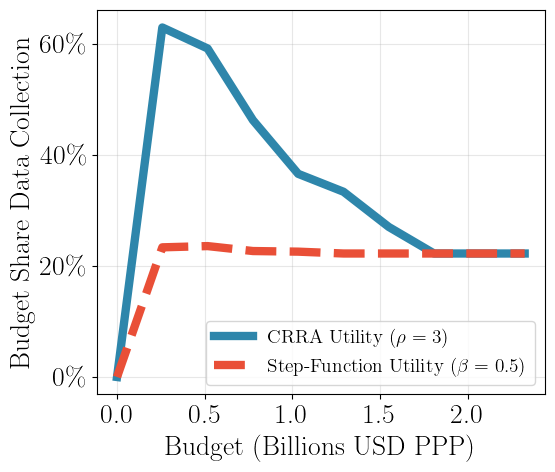

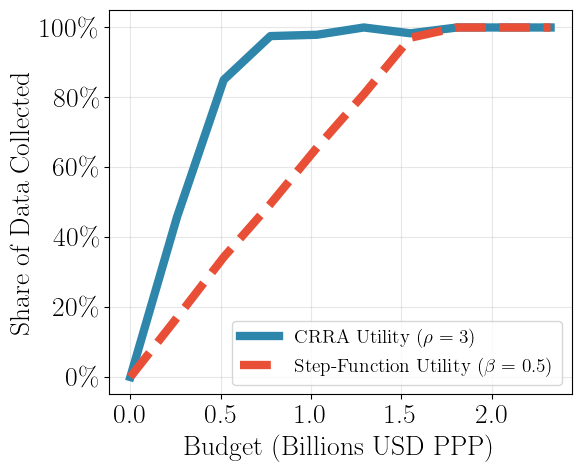

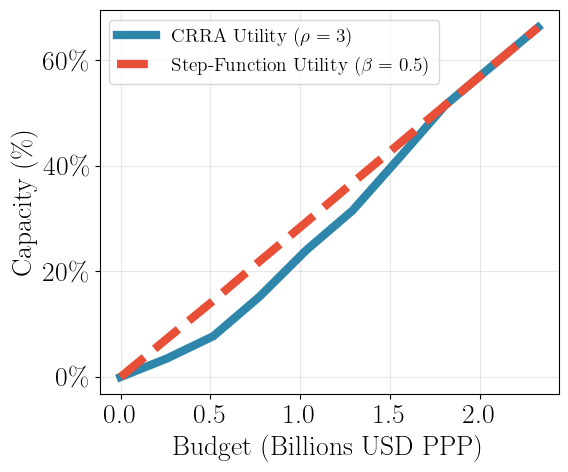

In [ ]:
axes = comparison_crra.plot_budget_optimization(results=results_crra,
                                                 xlabels=3*['Budget (Billions USD PPP)'],
                                                ylabels=['Budget Share Data Collection',
                                                'Share of Data Collected', r'Capacity ($\%$)'],
                                                color='#2E86AB',
                                                label=r'CRRA Utility ($\rho=3$)',
                                                figsize=(6,5))

axes = comparison_crra.plot_budget_optimization(results=results_step, axes=axes,
                                                xlabels=3*['Budget (Billions USD PPP)'],
                                                ylabels=['Budget Share Data Collection',
                                                    'Share of Data Collected', r'Capacity ($\%$)'],
                                                color='#E94F37',
                                                linestyle='--',
                                                label=r'Step-Function Utility ($\beta=0.5$)',
                                                figsize=(6,4))

axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

scale = 27_300_000 / problem_crra.data.n / 1e9
desired_billions = [0, 0.5, 1, 1.5, 2]
ticks_in_original = [b / scale for b in desired_billions]

for ax in axes:
    ax.set_xticks(ticks_in_original)
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p, s=scale: f'{x * s:.1f}'))
    ax.legend()

## What is the relative value of improving prediction via test-time data collection vs. increasing capacity vs. increasing treatment intensity? 

In [37]:
data = AllocationData(df = data_list)
policy = RankingPolicy(ascending=True)

utility_crra = CRRAUtility(rho=3.0, b=100)


In [ ]:
capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=100
)

### Low Initial Share Labeled

In [43]:
utility_crra = CRRAUtility(rho=3.0, b=100)
constraint = CoverageConstraint(max_coverage=0.05, population_size=data.n)

set_initial_data_fraction = DataLabelingLever.from_data(
    data=data,
    label_share=0.01,
    ascending=True,
    cost_per_label=13.0,
    seed=42,
    marginal=False
)

problem_crra = AllocationProblem(data = data,
                                utility = utility_crra, 
                                constraint = constraint,
                                policy=policy)

problem_crra = set_initial_data_fraction.apply(problem_crra)

datalabeling_lever = DataLabelingLever.from_data(
    name="Data collection",
    data=data,
    label_share=0.1,
    baseline_share=0.01,
    cost_per_label=13.0,
    ascending=True,
    seed=42,
    marginal=True
)

In [44]:
results_crra = optimize_budget_with_residual_benefit(problem_crra,
                            lever2=capacity_lever,
                            lever1=datalabeling_lever,
                            budget_range=[1, 100000],
                            n_budget_points=30,
                            grid_density=30,
                            verbose=True)

Budget 30/30: $100000


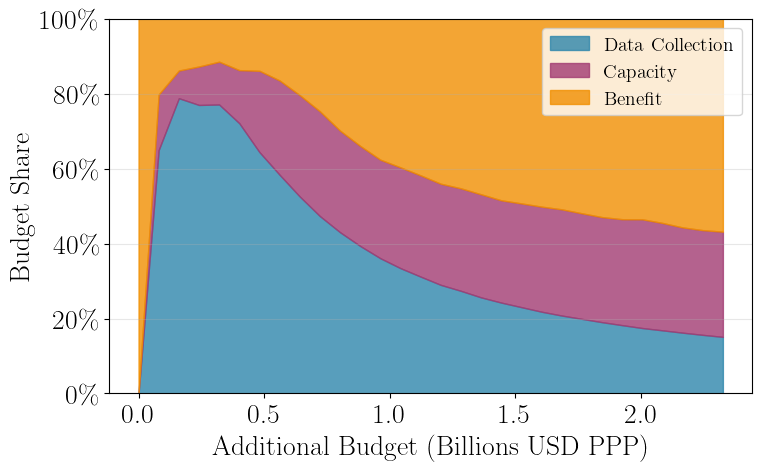

In [ ]:
ax = plot_budget_allocation_stacked(results_crra,
                               labels=[r'Data Collection', 'Capacity', 'Benefit'],
                               xlabel='Additional Budget (Billions USD PPP)')

scale = 27_300_000 / problem_crra.data.n / 1e9
desired_billions = [0, 0.5, 1, 1.5, 2]
ticks_in_original = [b / scale for b in desired_billions]
ax.set_xticks(ticks_in_original)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p, s=scale: f'{x * s:.1f}'))

### High Initial Share Labeled

In [46]:
utility_crra = CRRAUtility(rho=3.0, b=100)
constraint = CoverageConstraint(max_coverage=0.05, population_size=data.n)

set_initial_data_fraction = DataLabelingLever.from_data(
    data=data,
    label_share=0.7,
    ascending=True,
    cost_per_label=13.0,
    seed=42,
    marginal=False
)

problem_crra = AllocationProblem(data = data,
                                utility = utility_crra, 
                                constraint = constraint,
                                policy=policy)

problem_crra = set_initial_data_fraction.apply(problem_crra)

datalabeling_lever = DataLabelingLever.from_data(
    name="Data collection",
    data=data,
    label_share=0.1,
    baseline_share=0.7,
    cost_per_label=13.0,
    ascending=True,
    seed=42,
    marginal=True
)

In [47]:
results_crra = optimize_budget_with_residual_benefit(problem_crra,
                            lever2=capacity_lever,
                            lever1=datalabeling_lever,
                            budget_range=[1, 100000],
                            n_budget_points=30,
                            grid_density=30,
                            verbose=True)

Budget 30/30: $100000


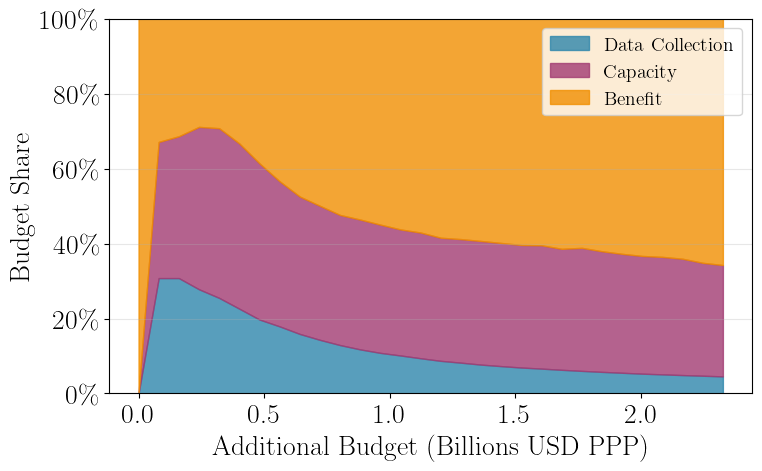

In [ ]:
ax = plot_budget_allocation_stacked(results_crra,
                               labels=[r'Data Collection', 'Capacity', 'Benefit'],
                               xlabel='Additional Budget (Billions USD PPP)')

scale = 27_300_000 / problem_crra.data.n / 1e9
desired_billions = [0, 0.5, 1, 1.5, 2]
ticks_in_original = [b / scale for b in desired_billions]
ax.set_xticks(ticks_in_original)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p, s=scale: f'{x * s:.1f}'))

### Low Initial Capacity

In [ ]:
constraint = CoverageConstraint(max_coverage=0.005, population_size=data.n)

set_initial_data_fraction = DataLabelingLever.from_data(
    data=data,
    label_share=0.2,
    ascending=True,
    cost_per_label=13.0,
    seed=42,
    marginal=False
)

problem_crra = AllocationProblem(data = data,
                            utility = utility_crra, 
                            constraint = constraint,
                            policy=policy)

problem_crra = set_initial_data_fraction.apply(problem_crra)



datalabeling_lever = DataLabelingLever.from_data(
    name="Data collection",
    data=data,
    label_share=0.1,
    baseline_share=0.2,
    cost_per_label=13.0,
    ascending=True,
    seed=42,
    marginal=True
)

In [8]:
results_crra = optimize_budget_with_residual_benefit(problem_crra,
                            lever2=capacity_lever,
                            lever1=datalabeling_lever,
                            budget_range=[1, 100000],
                            n_budget_points=30,
                            grid_density=30,
                            verbose=True)

Budget 30/30: $100000


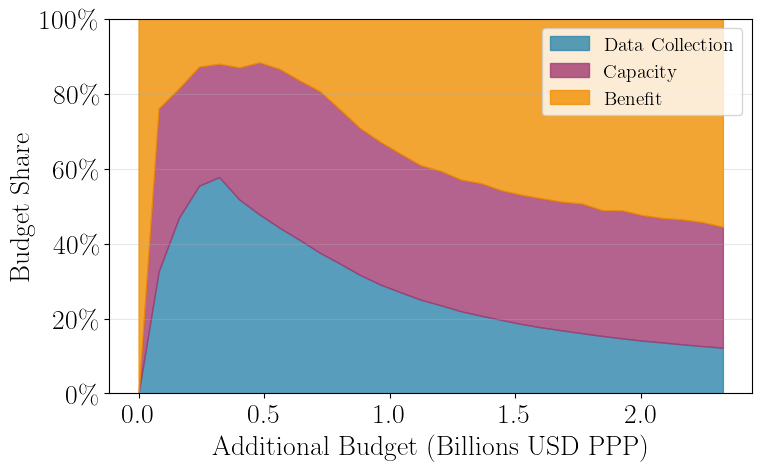

In [ ]:
ax = plot_budget_allocation_stacked(results_crra,
                               labels=[r'Data Collection', 'Capacity', 'Benefit'],
                               xlabel='Additional Budget (Billions USD PPP)')

scale = 27_300_000 / problem_crra.data.n / 1e9
desired_billions = [0, 0.5, 1, 1.5, 2]
ticks_in_original = [b / scale for b in desired_billions]
ax.set_xticks(ticks_in_original)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p, s=scale: f'{x * s:.1f}'))

### High Initial Capacity

In [ ]:
constraint = CoverageConstraint(max_coverage=0.4, population_size=data.n)

set_initial_data_fraction = DataLabelingLever.from_data(
    data=data,
    label_share=0.2,
    ascending=True,
    cost_per_label=13.0,
    seed=42,
    marginal=False
)

problem_crra = AllocationProblem(data = data,
                            utility = utility_crra, 
                            constraint = constraint,
                            policy=policy)

problem_crra = set_initial_data_fraction.apply(problem_crra)



datalabeling_lever = DataLabelingLever.from_data(
    name="Data collection",
    data=data,
    label_share=0.1,
    baseline_share=0.2,
    cost_per_label=13.0,
    ascending=True,
    seed=42,
    marginal=True
)

In [13]:
results_crra = optimize_budget_with_residual_benefit(problem_crra,
                            lever2=capacity_lever,
                            lever1=datalabeling_lever,
                            budget_range=[1, 100000],
                            n_budget_points=30,
                            grid_density=30,
                            verbose=True)

Budget 30/30: $100000


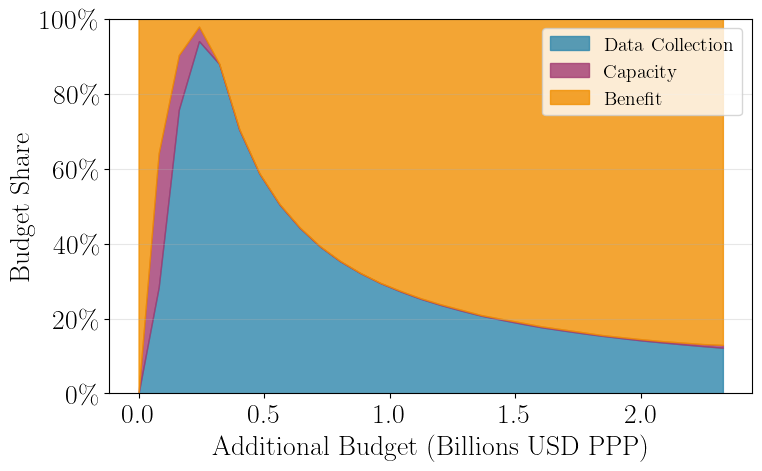

In [ ]:
ax = plot_budget_allocation_stacked(results_crra,
                               labels=[r'Data Collection', 'Capacity', 'Benefit'],
                               xlabel='Additional Budget (Billions USD PPP)')

scale = 27_300_000 / problem_crra.data.n / 1e9
desired_billions = [0, 0.5, 1, 1.5, 2]
ticks_in_original = [b / scale for b in desired_billions]
ax.set_xticks(ticks_in_original)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p, s=scale: f'{x * s:.1f}'))

### Low Initial Transfer Size

In [57]:
utility_crra = CRRAUtility(rho=3.0, b=10)

constraint = CoverageConstraint(max_coverage=0.05, population_size=data.n)

set_initial_data_fraction = DataLabelingLever.from_data(
    data=data,
    label_share=0.2,
    ascending=True,
    cost_per_label=13.0,
    seed=42,
    marginal=False
)

problem_crra = AllocationProblem(data = data,
                                utility = utility_crra, 
                                constraint = constraint,
                                policy=policy)

problem_crra = set_initial_data_fraction.apply(problem_crra)



datalabeling_lever = DataLabelingLever.from_data(
    name="Data collection",
    data=data,
    label_share=0.1,
    baseline_share=0.2,
    cost_per_label=13.0,
    ascending=True,
    seed=42,
    marginal=True
)

capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=10
)

In [58]:
results_crra = optimize_budget_with_residual_benefit(problem_crra,
                            lever2=capacity_lever,
                            lever1=datalabeling_lever,
                            budget_range=[1, 100000],
                            n_budget_points=30,
                            grid_density=30,
                            verbose=True)

Budget 30/30: $100000


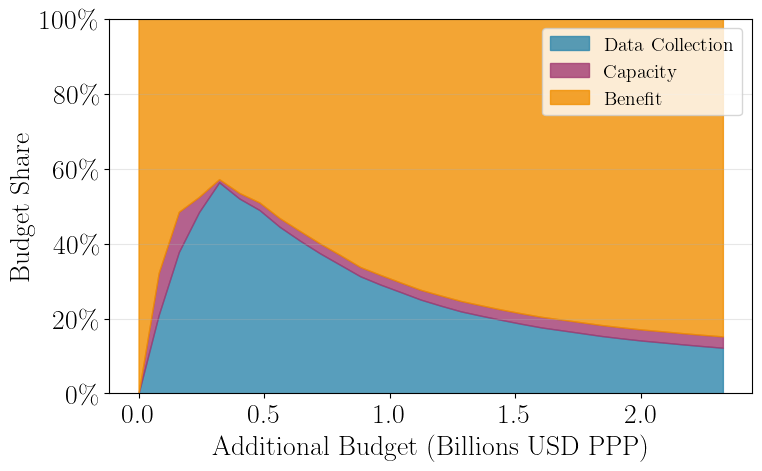

In [ ]:
ax = plot_budget_allocation_stacked(results_crra,
                               labels=[r'Data Collection', 'Capacity', 'Benefit'],
                               xlabel='Additional Budget (Billions USD PPP)')

scale = 27_300_000 / problem_crra.data.n / 1e9
desired_billions = [0, 0.5, 1, 1.5, 2]
ticks_in_original = [b / scale for b in desired_billions]
ax.set_xticks(ticks_in_original)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p, s=scale: f'{x * s:.1f}'))

### High Initial Transfer Size

In [8]:
utility_crra = CRRAUtility(rho=3.0, b=1000)

constraint = CoverageConstraint(max_coverage=0.05, population_size=data.n)

set_initial_data_fraction = DataLabelingLever.from_data(
    data=data,
    label_share=0.2,
    ascending=True,
    cost_per_label=13.0,
    seed=42,
    marginal=False
)

problem_crra = AllocationProblem(data = data,
                                utility = utility_crra, 
                                constraint = constraint,
                                policy=policy)

problem_crra = set_initial_data_fraction.apply(problem_crra)



datalabeling_lever = DataLabelingLever.from_data(
    name="Data collection",
    data=data,
    label_share=0.1,
    baseline_share=0.2,
    cost_per_label=13.0,
    ascending=True,
    seed=42,
    marginal=True
)

capacity_lever = ExpandCoverageLever(
    name="Capacity Increase",
    coverage_increase=0.1,
    marginal_cost_per_person=1000
)

In [9]:
results_crra = optimize_budget_with_residual_benefit(problem_crra,
                            lever2=capacity_lever,
                            lever1=datalabeling_lever,
                            budget_range=[1, 100000],
                            n_budget_points=30,
                            grid_density=30,
                            verbose=True)

Budget 30/30: $100000


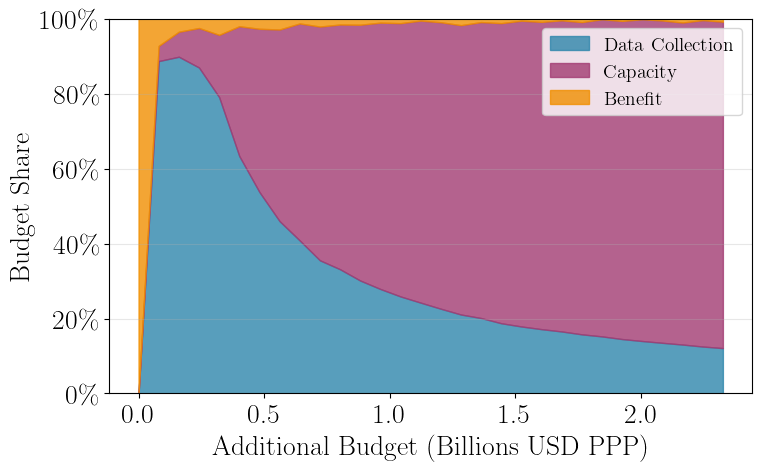

In [ ]:
ax = plot_budget_allocation_stacked(results_crra,
                               labels=[r'Data Collection', 'Capacity', 'Benefit'],
                               xlabel='Additional Budget (Billions USD PPP)')

scale = 27_300_000 / problem_crra.data.n / 1e9
desired_billions = [0, 0.5, 1, 1.5, 2]
ticks_in_original = [b / scale for b in desired_billions]
ax.set_xticks(ticks_in_original)
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p, s=scale: f'{x * s:.1f}'))